In [1]:
## The instrument needs to be working in LANG = SCPI to be qcodes compatible

from pyvisa import VisaIOError
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from IPython.display import clear_output
from time import sleep
from Keythley_2450 import Keithley2450 

from qcodes.dataset import (
    Measurement,
    initialise_database,
    new_experiment,
    plot_dataset,
)
from qcodes.instrument_drivers.Keithley import Keithley2450

lo = SGS100A_driver('TCPIP0::192.168.0.32::inst0::INSTR')
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
smu = Keithley2450('QRF_SMU','TCPIP0::192.168.0.4::inst0::INSTR')

Connected to: KEITHLEY INSTRUMENTS 2450 (serial:04632152, firmware:1.7.12b) in 0.02s


In [6]:
smu.reset()
vna.open()
lo.open()

Center frequency: 7333084990.00 Hz
FWHM: 3481.46 kHz
Quality Factor: 2106.33


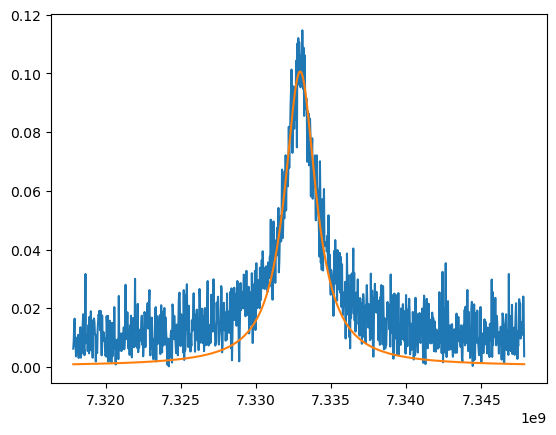

In [3]:
#Update central frequency
f_c = 7332844990.00   # Initial Frequency 
freqs, mag, phase = meas_spectrum(vna, f_c, f_span = 30, power = -60, npoints=1001,sleep_t = 5)
    
f_c, Qf, fwhm = Q(freqs,mag, True)

print('Center frequency: %2.2f Hz'%f_c)
print('FWHM: %2.2f kHz'%(fwhm*1e-3))
print('Quality Factor: %2.2f'%Qf)

In [23]:
from datetime import datetime
params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'twotone_fpsweep'
params['qubit_name'] = 'S3_FRAN_2Q_qbit01'
params['vna_power'] = -60
params['lo_power'] = -10
params['temp'] = 10 #mK
params['comment'] = "Flux Att: 10dB @ 4 K + 3dB @ 10 K \n" +\
                    "# Drive Att: 52dB Total (30dB @ 20 mK)" +\
                    "# No TWPA" +\
                    "# Connection Diagram: TII 2q 06-10-23" +\
                    "# Clean current source\n"

# Sweep Parameters
qubitFreqInitial = 5600
qubitFreqFinal = 5900
qubitFreqStep = 5
qubitFreq_array = np.arange(qubitFreqInitial,qubitFreqFinal,qubitFreqStep)

flux_current_initial = -200e-6 # A
flux_current_final = 200e-6
flux_current_step = 5e-6
flux_current_array = np.arange(flux_current_initial,flux_current_final,flux_current_step)

#Setup VNA for two tone measurement
def vna_2tone(f_c):
    meas_spectrum(vna, f_c = f_c, 
    f_span= 0.002, # VNA in unit MHz
    power = params['vna_power'],
    npoints = 3, 
    sleep_t=0.5)
vna_2tone(f_c)
vna.start_rf
delay = 0.4

#Initialize the Local Oscillator
lo.set_level(params['lo_power']) # dBm
lo.start_rf()

#Intiialize SMU
smu.terminals("front")
smu.source.function("current")
smu.source.current(1E-6)  # Put 1uA through the resistor


tt = ((delay+1)*(len(flux_current_array)*len(qubitFreq_array))+ len(flux_current_array)*7)/60.0
print('Estimated time for test = %2.2f min'%tt)

Estimated time for test = 289.33 min


In [2]:
#Initialize variables for storage
mags = np.ndarray((len(qubitFreq_array),len(flux_current_array)))
phases = np.ndarray((len(qubitFreq_array),len(flux_current_array)))

mags[:] = 0.002
phases[:] = 0

voltage = smu.sense.function("voltage")

def update_fc(f_c):
    vna.start_rf()
    freqs, mag, _ = meas_spectrum(vna, f_c, f_span = 30, power = -60, npoints=1001,sleep_t = 5)
    f_c, _, _ = Q(freqs,mag, False)
    vna.stop_rf()
    return f_c

vna.start_rf()
try:
    for idx_power, flux_current in enumerate(flux_current_array):
        vna.stop_rf()
        lo.stop_rf()
        smu.source.current(flux_current)
        with smu.output_enabled.set_to(True):
            voltage = smu.sense.voltage()
            f_c = update_fc(f_c)
            print(f_c)
        sleep(0.5)
        vna_2tone(f_c)
        sleep(0.1)
        vna.start_rf()
        lo.start_rf()
        for idx,qfreq in enumerate(qubitFreq_array):    
            clear_output(wait=True)
            lo.set_RF(qfreq)
            sleep(0.01)
            with smu.output_enabled.set_to(True):
                voltage = smu.sense.voltage()
                vna.reset_average()
                sleep(delay)
                mag, phase =  vna.get_data()
            mags[idx,idx_power] = mag[1]
            phases[idx,idx_power] = phase[1]
            plt.pcolor(flux_current_array*1e6,qubitFreq_array,mags)
            plt.show()
    Z = toComplex(mags,phases)
except KeyboardInterrupt:
    print("Stopped")
finally:
    lo.stop_rf()
    vna.stop_rf()
    smu.output_enabled(0)


lo.stop_rf()
vna.stop_rf()

KeyboardInterrupt: 

In [ ]:
with smu.output_enabled.set_to(True):
    voltage = smu.sense.voltage()


In [3]:
smu.close()